# The results plot in the paper.

In [1]:
%matplotlib inline

In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

import kepler_kinematics as kek

from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from matplotlib import gridspec

plotpar = {'axes.labelsize': 30,
                  'font.size': 12,
                  'legend.fontsize': 15,
                  'xtick.labelsize': 15,
                  'ytick.labelsize': 15,
                  'text.usetex': True}
plt.rcParams.update(plotpar)

Load the data file.

In [3]:
df = pd.read_csv("../kepler_kinematics/gaia_kepler_lamost.csv")

/Users/rangus/Applications/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (1,2,3,20,21,22,28,30,54,55,56,74,76,155,156,176) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Load the results file.

In [4]:
results = pd.read_csv("../data/all_kepler.csv")

Merge

In [5]:
adf = pd.merge(df, results, on="kepid", how="right")

In [58]:
def confidence_ellipse_mod(x, y, cov, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

#     cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

Define variables for plotting

In [96]:
box = 200

lnD = np.log(df.r_est.values * 1e-3)
m = np.isfinite(df.vx.values) & np.isfinite(df.vy.values) & np.isfinite(df.vz.values) & np.isfinite(lnD)
vx, vy, vz, lnD = df.vx.values[m], df.vy.values[m], df.vz.values[m], lnD[m]

vx_c, vy_c, vz_c, lnD_c = adf.vx_inferred.values, adf.vy_inferred.values, adf.vz_inferred.values, adf.lndistance_inferred.values
medx, medy, medz = np.median(vx_c), np.median(vy_c), np.median(vz_c)
xlim, ylim, zlim, dlim = (medx-box, medx+box), (medy-box, medy+box), (medz-box, medz+box), (-3, 2)

alpha, ms, lw, lalpha = .2, 2, 3, 1.
color = "k" #lightseagreen"
cmap = "viridis_r"
vmin, vmax = 0, .1

In [113]:
mu, cov = kek.get_prior()
print(np.shape(cov), np.shape(mu))

mvn = multivariate_normal(mu, cov)
p = mvn.pdf(np.vstack((vx_c, vy_c, vz_c, lnD_c)).T)

(4, 4) (4,)


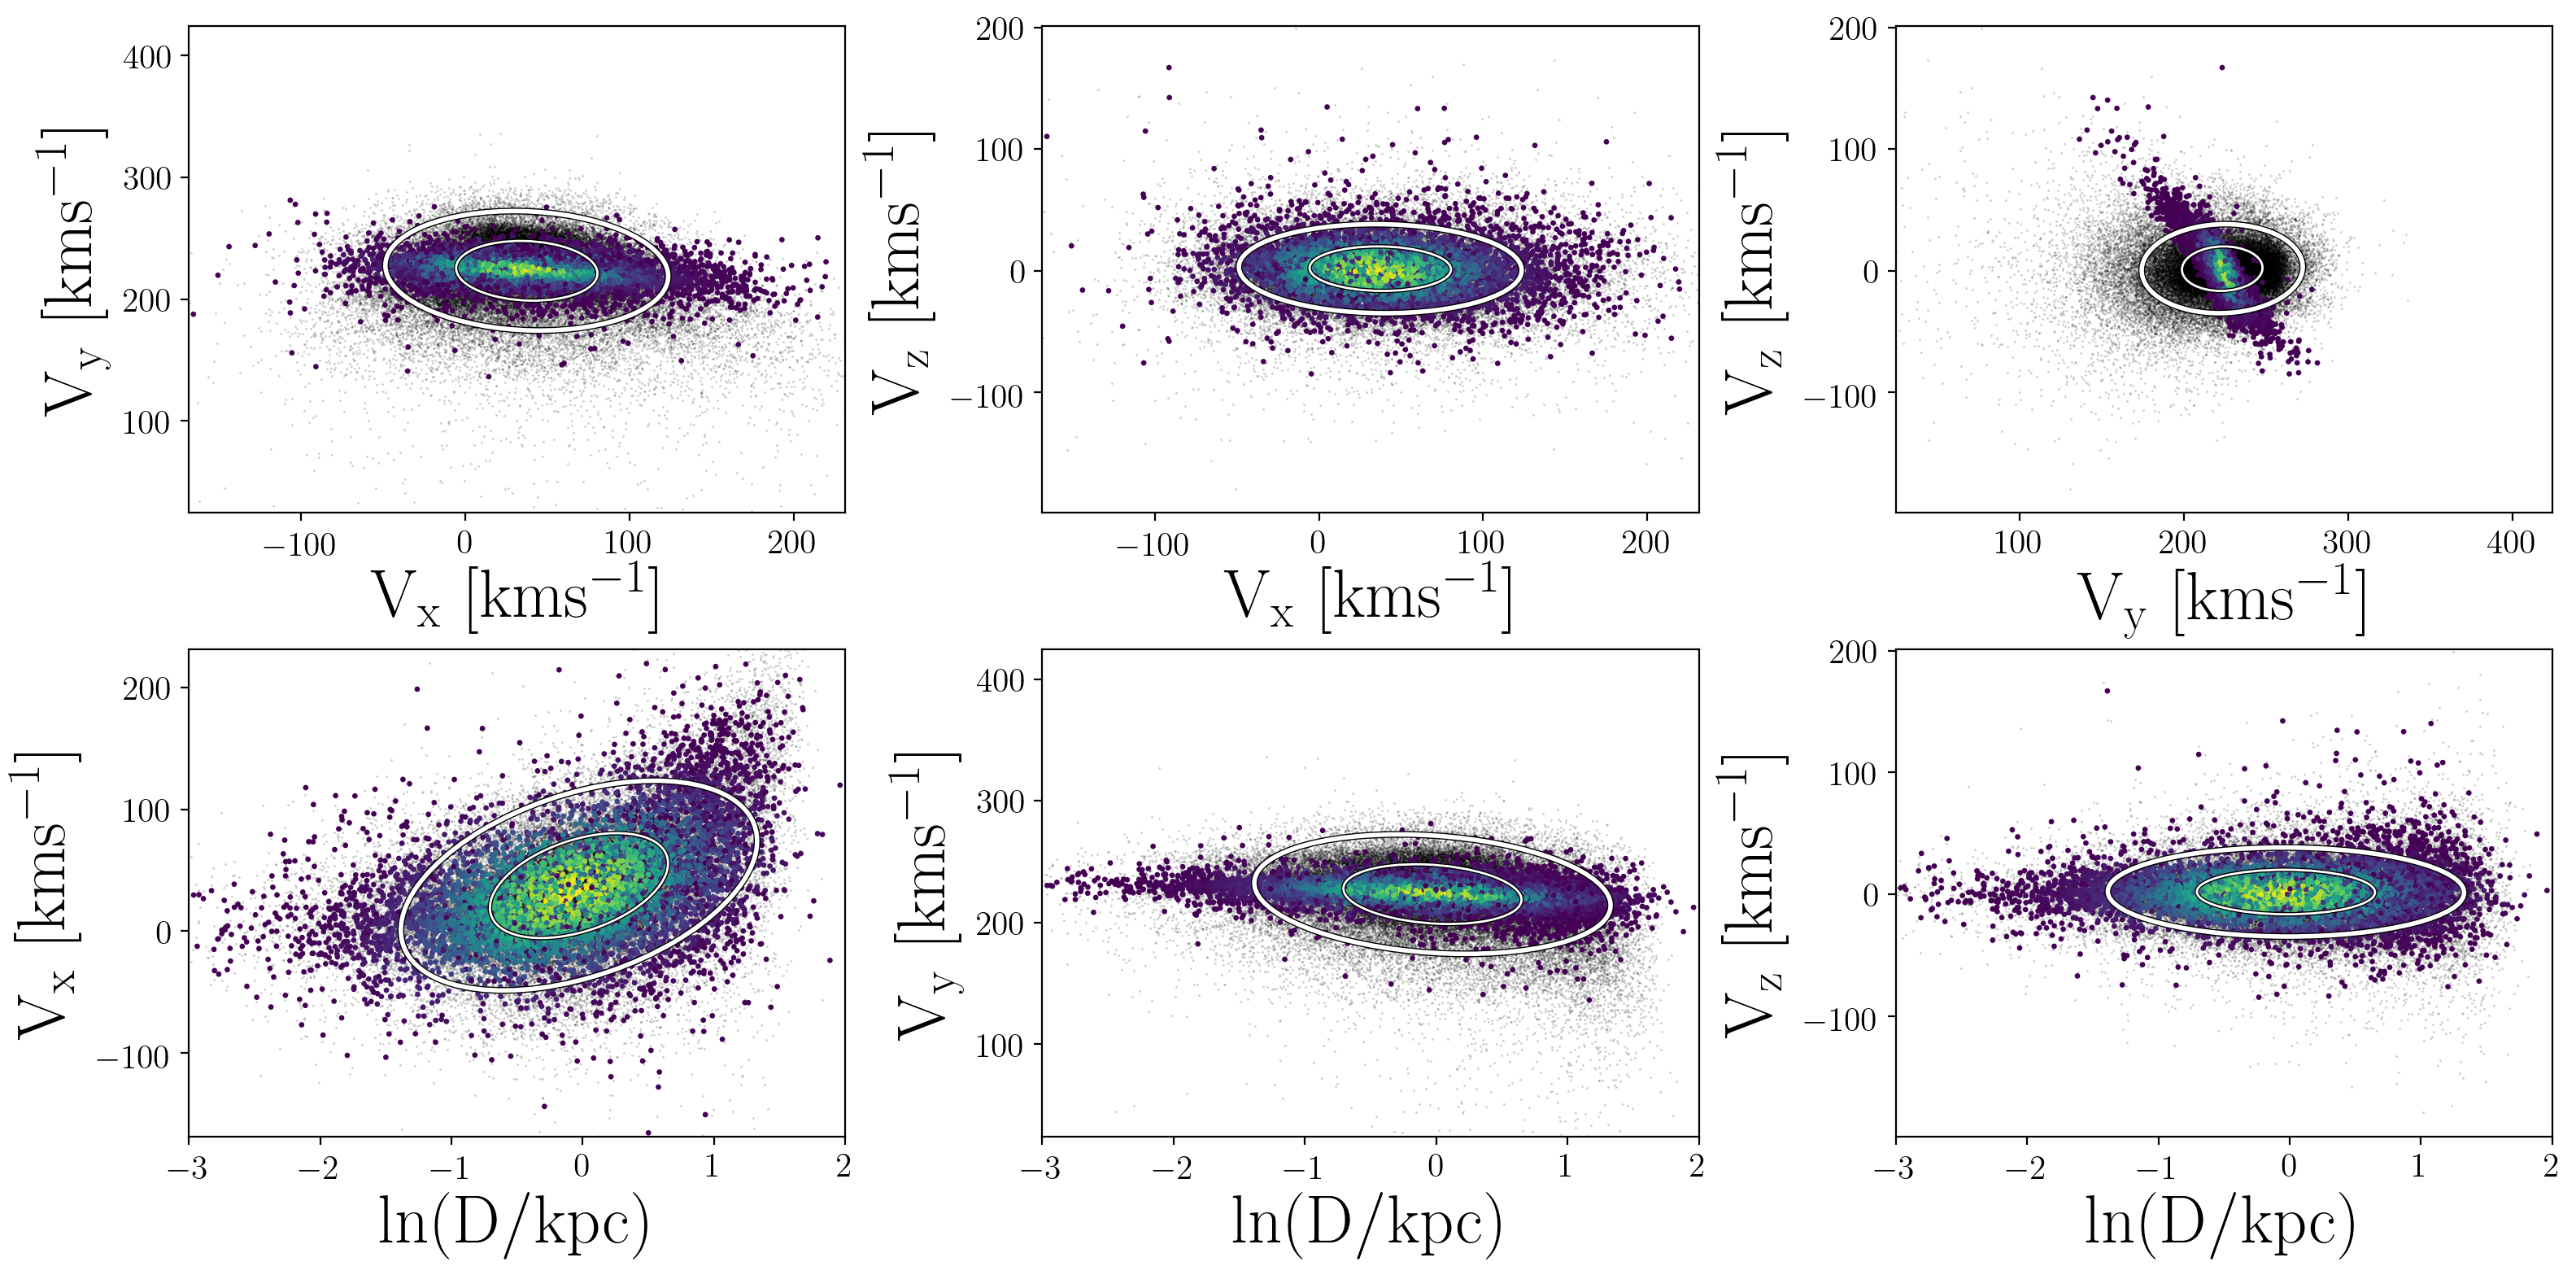

In [115]:
fig = plt.figure(figsize=(16, 8), dpi=200)
ax0 = fig.add_subplot(231)
ax0.plot(vx, vy, "k.", ms=ms, alpha=alpha, mec="none", rasterized=True, zorder=0)
# ax0.plot(vx_c, vy_c, "C1.", ms=ms, alpha=.5, mec="none", rasterized=True, zorder=1)
cb=ax0.scatter(vx_c, vy_c, c=p, s=2, rasterized=True, zorder=1)
_cov = np.array([[cov[0, 0], cov[0, 1]], [cov[1, 0], cov[1, 1]]])
confidence_ellipse_mod(vx_c, vy_c, _cov, ax0, n_std=2, lw=lw, edgecolor=color, zorder=1, alpha=lalpha)
confidence_ellipse_mod(vx_c, vy_c, _cov, ax0, n_std=2, lw=2, edgecolor="w", zorder=2, alpha=lalpha)
confidence_ellipse_mod(vx_c, vy_c, _cov, ax0, n_std=1, lw=2, edgecolor=color, zorder=1, alpha=lalpha)
confidence_ellipse_mod(vx_c, vy_c, _cov, ax0, n_std=1, lw=1, edgecolor="w", zorder=2, alpha=lalpha)
# plt.colorbar(cb)

ax0.set_xlim(xlim)
ax0.set_ylim(ylim)
ax0.set_xlabel("$\mathrm{V_x~[kms^{-1}]}$")
ax0.set_ylabel("$\mathrm{V_y~[kms^{-1}]}$")

ax1 = fig.add_subplot(232)
ax1.plot(vx, vz, "k.", ms=ms, alpha=alpha, mec="none", rasterized=True, zorder=0)
# ax1.plot(vx_c, vz_c, "C1.", ms=ms, alpha=.5, mec="none", rasterized=True, zorder=1)
cb=ax1.scatter(vx_c, vz_c, c=p, s=2, rasterized=True, zorder=1)
_cov = np.array([[cov[0, 0], cov[0, 2]], [cov[2, 0], cov[2, 2]]])
confidence_ellipse_mod(vx_c, vz_c, _cov, ax1, n_std=2, lw=lw, edgecolor=color, zorder=1, alpha=lalpha)
confidence_ellipse_mod(vx_c, vz_c, _cov, ax1, n_std=2, lw=2, edgecolor="w", zorder=2, alpha=lalpha)
confidence_ellipse_mod(vx_c, vz_c, _cov, ax1, n_std=1, lw=2, edgecolor=color, zorder=1, alpha=lalpha)
confidence_ellipse_mod(vx_c, vz_c, _cov, ax1, n_std=1, lw=1, edgecolor="w", zorder=2, alpha=lalpha)
ax1.set_xlim(xlim)
ax1.set_ylim(zlim)
ax1.set_xlabel("$\mathrm{V_x~[kms^{-1}]}$")
ax1.set_ylabel("$\mathrm{V_z~[kms^{-1}]}$")

ax2 = fig.add_subplot(233)
ax2.plot(vy, vz, "k.", ms=ms, alpha=alpha, mec="none", rasterized=True, zorder=0)
# ax2.plot(vy_c, vz_c, "C1.", ms=ms, alpha=.5, mec="none", rasterized=True, zorder=1)
cb=ax2.scatter(vy_c, vz_c, c=p, s=2, rasterized=True, zorder=1)
_cov = np.array([[cov[1, 1], cov[1, 2]], [cov[2, 1], cov[2, 2]]])
confidence_ellipse_mod(vy_c, vz_c, _cov, ax2, n_std=2, lw=lw, edgecolor=color, zorder=1, alpha=lalpha)
confidence_ellipse_mod(vy_c, vz_c, _cov, ax2, n_std=2, lw=2, edgecolor="w", zorder=1, alpha=lalpha)
confidence_ellipse_mod(vy_c, vz_c, _cov, ax2, n_std=1, lw=2, edgecolor=color, zorder=1, alpha=lalpha)
confidence_ellipse_mod(vy_c, vz_c, _cov, ax2, n_std=1, lw=1, edgecolor="w", zorder=1, alpha=lalpha)
ax2.set_xlim(ylim)
ax2.set_ylim(zlim)
ax2.set_xlabel("$\mathrm{V_y~[kms^{-1}]}$")
ax2.set_ylabel("$\mathrm{V_z~[kms^{-1}]}$")

ax3 = fig.add_subplot(234)
ax3.plot(lnD, vx, "k.", ms=ms, alpha=alpha, mec="none", rasterized=True, zorder=0)
# ax3.plot(lnD_c, vx_c, "C1.", ms=ms, alpha=.5, mec="none", rasterized=True, zorder=1)
cb=ax3.scatter(lnD_c, vx_c, c=p, s=2, rasterized=True, zorder=1)
_cov = np.array([[cov[3, 3], cov[3, 0]], [cov[0, 3], cov[0, 0]]])
confidence_ellipse_mod(lnD_c, vx_c, _cov, ax3, n_std=2, lw=lw, edgecolor=color, zorder=1, alpha=lalpha)
confidence_ellipse_mod(lnD_c, vx_c, _cov, ax3, n_std=2, lw=2, edgecolor="w", zorder=1, alpha=lalpha)
confidence_ellipse_mod(lnD_c, vx_c, _cov, ax3, n_std=1, lw=2, edgecolor=color, zorder=1, alpha=lalpha)
confidence_ellipse_mod(lnD_c, vx_c, _cov, ax3, n_std=1, lw=1, edgecolor="w", zorder=1, alpha=lalpha)
ax3.set_ylabel("$\mathrm{V_x~[kms^{-1}]}$")
ax3.set_xlabel("$\mathrm{\ln(D/kpc)}$")
ax3.set_xlim(dlim)
ax3.set_ylim(xlim)

ax4 = fig.add_subplot(235)
ax4.plot(lnD, vy, "k.", ms=ms, alpha=alpha, mec="none", rasterized=True, zorder=0)
# ax4.plot(lnD_c, vy_c, "C1.", ms=ms, alpha=.5, mec="none", rasterized=True, zorder=1)
cb=ax4.scatter(lnD_c, vy_c, c=p, s=2, rasterized=True, zorder=1)
_cov = np.array([[cov[3, 3], cov[3, 1]], [cov[1, 3], cov[1, 1]]])
confidence_ellipse_mod(lnD_c, vy_c, _cov, ax4, n_std=2, lw=lw, edgecolor=color, zorder=1, alpha=lalpha)
confidence_ellipse_mod(lnD_c, vy_c, _cov, ax4, n_std=2, lw=2, edgecolor="w", zorder=1, alpha=lalpha)
confidence_ellipse_mod(lnD_c, vy_c, _cov, ax4, n_std=1, lw=2, edgecolor=color, zorder=1, alpha=lalpha)
confidence_ellipse_mod(lnD_c, vy_c, _cov, ax4, n_std=1, lw=1, edgecolor="w", zorder=1, alpha=lalpha)
ax4.set_ylabel("$\mathrm{V_y~[kms^{-1}]}$")
ax4.set_xlabel("$\mathrm{\ln(D/kpc)}$")
ax4.set_xlim(dlim)
ax4.set_ylim(ylim)

ax5 = fig.add_subplot(236)
ax5.plot(lnD, vz, "k.", ms=ms, alpha=alpha, mec="none", rasterized=True, zorder=0)
# ax5.plot(lnD_c, vz_c, "C1.", ms=ms, alpha=.5, mec="none", rasterized=True, zorder=1)
cb=ax5.scatter(lnD_c, vz_c, c=p, s=2, rasterized=True, zorder=1)
_cov = np.array([[cov[3, 3], cov[3, 2]], [cov[2, 3], cov[2, 2]]])
confidence_ellipse_mod(lnD_c, vz_c, _cov, ax5, n_std=2, lw=lw, edgecolor=color, zorder=1, alpha=lalpha)
confidence_ellipse_mod(lnD_c, vz_c, _cov, ax5, n_std=2, lw=2, edgecolor="w", zorder=1, alpha=lalpha)
confidence_ellipse_mod(lnD_c, vz_c, _cov, ax5, n_std=1, lw=2, edgecolor=color, zorder=1, alpha=lalpha)
confidence_ellipse_mod(lnD_c, vz_c, _cov, ax5, n_std=1, lw=1, edgecolor="w", zorder=1, alpha=lalpha)
ax5.set_ylabel("$\mathrm{V_z~[kms^{-1}]}$")
ax5.set_xlabel("$\mathrm{\ln(D/kpc)}$")
ax5.set_xlim(dlim)
ax5.set_ylim(zlim)

plt.tight_layout()
plt.subplots_adjust(hspace=.28, wspace=.3)
plt.savefig("../plots/results")

In [110]:
def resid_plot(vx, vy, vz, vx_inferred, vy_inferred, vz_inferred, vx_inferred_err, vy_inferred_err, vz_inferred_err,
               r_est, lndistance_inferred, p,
               ms=2, alpha=.1, box_size=150):

    fig = plt.figure(figsize=(16, 6), dpi=200)
#     gs = gridspec.GridSpec(2, 3, hspace=.0, wspace=.3, height_ratios=[1, 1])
    gs = gridspec.GridSpec(2, 4, hspace=.0, wspace=.4, height_ratios=[1, 1])

    ax0 = plt.subplot(gs[0, 0])
    xlims = (np.median(vx) - box_size, np.median(vx_inferred) + box_size)
    ax0.scatter(vx, vx_inferred, c=p, s=ms, alpha=alpha, rasterized=True, zorder=0)
    xs = np.linspace(xlims[0], xlims[1], 100)
    plt.plot(xs, xs, "k", ls="--", zorder=1)
    ax0.set_ylim(xlims)
    ax0.set_xlim(xlims)
#     ax0.set_ylabel("$\mathrm{V_x~inferred~[kms^{-1}]}$")
    ax0.set_xticklabels([])

    ax1 = plt.subplot(gs[0, 1])
    ylims = (np.median(vy) - box_size, np.median(vy_inferred) + box_size)
    ax1.scatter(vy, vy_inferred, c=p, s=ms, alpha=alpha, rasterized=True, zorder=0)
    xs = np.linspace(ylims[0], ylims[1], 100)
    plt.plot(xs, xs, "k", ls="--", zorder=1)
    ax1.set_xlim(ylims)
    ax1.set_ylim(ylims)
#     ax1.set_ylabel("$\mathrm{V_y~inferred~[kms^{-1}]}$")
    ax1.set_xticklabels([])

    ax2 = plt.subplot(gs[0, 2])
    zlims = (np.median(vz) - box_size, np.median(vz_inferred) + box_size)
    ax2.scatter(vz, vz_inferred, c=p, s=ms, alpha=alpha, rasterized=True, zorder=0)
    xs = np.linspace(zlims[0], zlims[1], 100)
    plt.plot(xs, xs, "k", ls="--", zorder=1)
    ax2.set_xlim(zlims)
    ax2.set_ylim(zlims)
#     ax2.set_ylabel("$\mathrm{V_z~inferred~[kms^{-1}]}$");
    ax2.set_xticklabels([])

    ax6 = plt.subplot(gs[0, 3])
    ax6.scatter(r_est, lndistance_inferred, c=p, s=ms, edgecolor="none", alpha=alpha, rasterized=True, zorder=0)
    xs = np.linspace(min(lndistance_inferred), max(lndistance_inferred), 100)
    ax6.plot(xs, xs, "k", ls="--", zorder=1)
    
    # Residual panels
    # ---------------------------------------------------------------------------------------------------
    
    ax3 = plt.subplot(gs[1, 0])
    ax3.scatter(vx, vx_inferred - vx, c=p, s=ms, edgecolor="none", alpha=alpha, rasterized=True, zorder=0)
    ax3.errorbar(np.median(vx - 40), -30, yerr=np.median(vx_inferred_err), fmt="k.", label="$\mathrm{Typical~uncertainty}$")
    ax3.axhline(0, color="k", ls="--", zorder=1)
    ax3.set_ylim(-box_size, box_size)
    ax3.set_xlim(xlims)
    ax3.set_xlabel("$\mathrm{V_x~true~[kms^{-1}]}$")
#     ax3.set_ylabel("$\mathrm{Residual~[kms^{-1}]}$")
    ax3.legend()

    ax4 = plt.subplot(gs[1, 1])
    ax4.scatter(vy, vy_inferred - vy, c=p, s=ms, edgecolor="none", alpha=alpha, rasterized=True, zorder=0)
    ax4.errorbar(np.median(vy - 40), -30, yerr=np.median(vy_inferred_err), fmt="k.")
    ax4.axhline(0, color="k", ls="--", zorder=1)
    ax4.set_ylim(-box_size, box_size)
    ax4.set_xlim(ylims)
    ax4.set_xlabel("$\mathrm{V_y~true~[ks^{-1}]}$")
#     ax4.set_ylabel("$\mathrm{Residual~[kms^{-1}]}$")

    ax5 = plt.subplot(gs[1, 2])
    ax5.scatter(vz, vz_inferred - vz, c=p, s=ms, edgecolor="none", alpha=alpha, rasterized=True, zorder=0)
    ax5.errorbar(np.median(vz - 40), -30, yerr=np.median(vz_inferred_err), fmt="k.")
    print("typical vz uncertainty = ", np.median(vz_inferred_err), np.median(vz_inferred_err/vz)*100)
    ax5.axhline(0, color="k", ls="--", zorder=1)
    ax5.set_ylim(-box_size, box_size)
    ax5.set_xlim(zlims)
    ax5.set_xlabel("$\mathrm{V_z~true~[ks^{-1}]}$")
#     ax5.set_ylabel("$\mathrm{Residual~[kms^{-1}]}$")

    ax6 = plt.subplot(gs[1, 3])
    ax6.scatter(r_est, lndistance_inferred-r_est, c=p, s=ms, edgecolor="none", alpha=alpha, rasterized=True, zorder=0)
    ax6.axhline(0, color="k", ls="--", zorder=1)
    ax6.set_ylim(-.5, .5)
        
    return fig

typical vz uncertainty =  5.0001025417474745 6.990067124966871


/Users/rangus/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  import sys


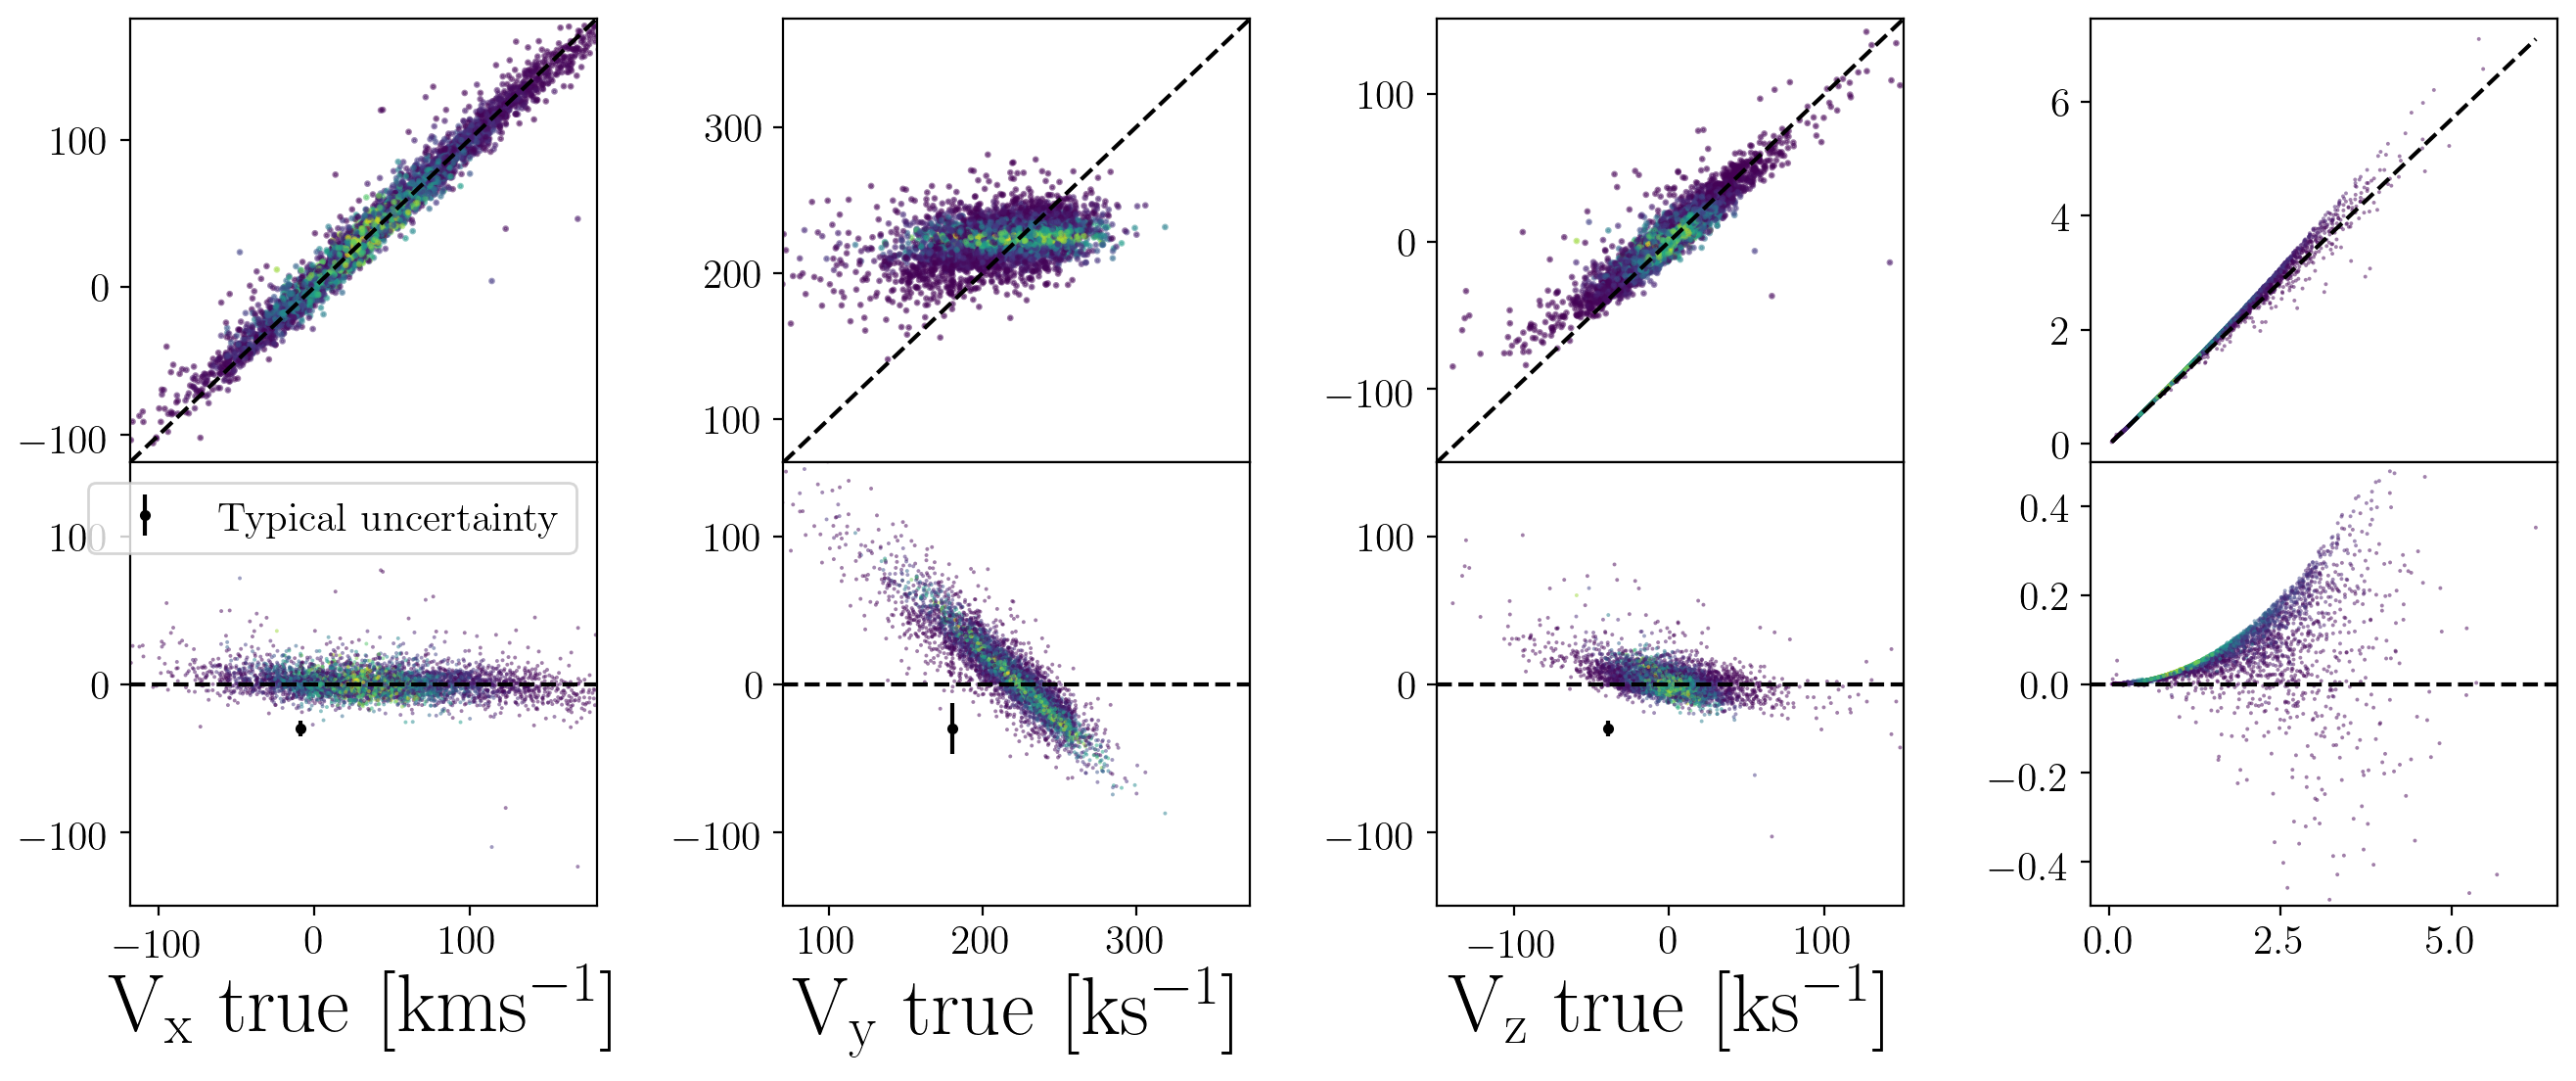

In [111]:
m = np.isfinite(adf.vx.values) & np.isfinite(adf.vy.values) & np.isfinite(adf.vz.values)
fig = resid_plot(adf.vx.values[m], adf.vy.values[m], adf.vz.values[m], adf.vx_inferred.values[m],
                 adf.vy_inferred.values[m], adf.vz_inferred.values[m], adf.vx_inferred_err.values[m],
                 adf.vy_inferred_err.values[m], adf.vz_inferred_err.values[m],
                 adf.r_est.values[m]*1e-3, np.exp(adf.lndistance_inferred.values[m]), p[m], alpha=.5)

plt.tight_layout()

In [82]:
mu, cov = kek.get_prior()
print(np.shape(cov), np.shape(mu))

(4, 4) (4,)


In [80]:
cov

array([[ 1.85544780e+03, -9.46664808e+01, -2.76317476e+01,
         1.24170994e+01],
       [-9.46664808e+01,  6.01848095e+02,  1.75608323e+01,
        -3.12163991e+00],
       [-2.76317476e+01,  1.75608323e+01,  3.34321276e+02,
        -1.75443452e-01],
       [ 1.24170994e+01, -3.12163991e+00, -1.75443452e-01,
         4.60081725e-01]])

In [74]:
def gauss(x, mu, sig):
    return 1./(sig * np.sqrt(2 * np.pi)) * np.exp(-.5 * (x - mu)**2 / sig**2)

223.26980765659724 601.8480954911166


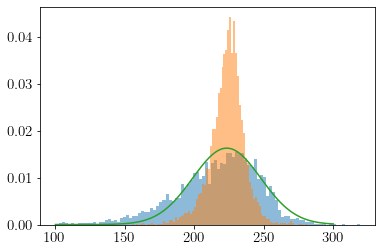

In [84]:
m = np.isfinite(adf.vy.values) & (adf.vy.values < 400) & (adf.vy.values > 100)
plt.hist(adf.vy.values[m], 100, density=True, alpha=.5);
plt.hist(adf.vy_inferred.values[m], 100, density=True, alpha=.5);
xs = np.linspace(100, 300, 100)
plt.plot(xs, gauss(xs, mu[1], np.sqrt(cov[1, 1])))
print(mu[1], cov[1, 1])

In [55]:
from scipy.stats import multivariate_normal
mu, cov = np.array([0, 0]), np.array([[1, 0.5], [.5, 1]])
mvn = multivariate_normal(mu, cov)
x = np.random.randn(1000, 2)
p = mvn.pdf(x)

(-3, 3)

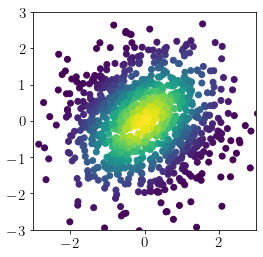

In [56]:
plt.figure(figsize=(4,4))
plt.scatter(x[:, 0], x[:, 1], c=p)
plt.xlim(-3, 3)
plt.ylim(-3, 3)